In [69]:
from pathlib import Path
import os
import sys

sys.path.append(Path(os.path.abspath('')).parent.parent)
os.chdir(Path(os.path.abspath('')).parent.parent)

import numpy as np
import pandas as pd 
import xarray as xr
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

import config.settings as cset

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import geopandas as gpd 
from matplotlib import colormaps as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import box
from matplotlib.gridspec import GridSpec

labelsize_small  = 13
labelsize_medium = 15
labelsize_large  = 17

## Load and Prepare Data

In [25]:
# loading & preparing gdp data
gdp_df   = pd.read_csv(cset.file_burke).loc[:, ['iso', 'scen', 'run', 'year', 'diff_SSP2', 'SSP2']].loc[:, ['iso', 'scen', 'run', 'year', 'diff_SSP2', 'SSP2']]
gdp_df   = gdp_df[gdp_df.scen != 'Ref1p5']
gdp_df.loc[gdp_df.scen == 'Refv2', 'scen'] = 'Ref'
# only keep data for year that we are interested in: 
gdp_baseline = gdp_df[gdp_df.year == 2015]['SSP2'].values
gdp_df   = gdp_df[(gdp_df.year == cset.gdp_target_year)].copy()
# adding for compatibility with characteristics df s
gdp_df['scen_run'] = gdp_df['scen'] + '_' + gdp_df['run'].astype(str)
gdp_isos  = gdp_df.iso.unique()

# loading and preparing tas_baseline
tas_df = pd.read_csv(cset.file_tas)
tas_df = tas_df[(tas_df.year == 2015) & (~tas_df['run'].str.contains('Ref_1p5'))].copy()
tas_df = tas_df.loc[tas_df.iso.isin(gdp_isos),:].copy()
tas_df = tas_df.rename(columns = {'run': 'scen_run', 'tas': 'tas_soc'})
tas_df = tas_df.dropna(subset=['tas_soc']).groupby('iso').filter(lambda x: x['tas_soc'].notna().all())
tas_df.loc[tas_df['scen_run'].str.contains('Refv2'), 'scen_run'] = tas_df['scen_run'].str.replace('Refv2', 'Ref')

# loading & preparing glmt data 
thrshld = 1.35
glmt_char_df = pd.read_csv(cset.path_MESMER_char / 'gmt_characteristics_thsld_135.csv', index_col = 0)

# merge datasets into a single regression dataset
regression_df = gdp_df.loc[:, ['iso', 'scen_run', 'diff_SSP2']].merge(glmt_char_df, left_on='scen_run', right_index=True)
regression_df['GDP_baseline'] = gdp_baseline
regression_df = regression_df.merge(tas_df[['iso', 'scen_run', 'tas_soc']], on=['iso', 'scen_run'], how='left')
#   - add baseline temperature values
regression_df['tas_baseline'] = regression_df.groupby('iso')['tas_soc'].transform('mean')
regression_df['tas_soc']      -= regression_df['tas_baseline']
regression_df                 = regression_df.sort_values(['iso', 'scen_run'])
regression_df['gmt_os']       = regression_df['gmt_max']- regression_df['gmt_eoc']
regression_df['log_gmt_cum']  = np.log(regression_df['gmt_cum'])

regression_df['gmt_delta_eoc'] = 1.5+regression_df['gmt_exc']*2-regression_df['gmt_eoc']
regression_df['gmt_delta_max'] = regression_df['gmt_max']-(1.5+2*regression_df['gmt_exc'])
# clear storage
# del gdp_df, glmt_char_df, tas_df

## Preprocess Regression Variables

In [26]:
# better target variable compared to regression_df['diff_SSP2']
y = np.log(regression_df['diff_SSP2'])

# Define predictor variables (excluding 'iso' and the target variable)
predictors = ['tas_soc', 'tas_baseline', 'gmt_cum', 'gmt_cum_adj', 'gmt_max', 'gmt_eoc', 'gmt_os', 'gmt_od', 'gmt_ud', 'gmt_exc', 'gmt_delta_eoc', 'gmt_delta_max', 'gmt_uxc', 'gmt_max_exc', 'gmt_eoc_exc']
# Generate second-order terms
poly       = PolynomialFeatures(2, interaction_only=False, include_bias=False)
X_poly     = poly.fit_transform(regression_df[predictors])
X_poly_std = StandardScaler().fit_transform(X_poly)
# Extract polynomial feature names
poly_feature_names  = poly.get_feature_names_out(predictors)
predictor_df        = pd.DataFrame(X_poly, columns = poly_feature_names)
regression_df.index = predictor_df.index
# interactions with tas_baseline 
interaction_terms   = [f for f in poly_feature_names if (('tas_baseline' in f) & (f != 'tas_baseline') & (f != 'tas_baseline^2')) | ('gmt_eoc' in f)]
# Combine original predictors, interaction terms, and polynomial features 
all_predictors     = list(predictors) + list(interaction_terms) + list([f+'^2' for f in predictors])
# intercept matrix for country fixed effects  
n_countries = int(len(regression_df)/1000)
X_intercept = np.zeros((len(regression_df), n_countries))
for i in range(n_countries):
    X_intercept[i*1000:(i+1)*1000, i] = 1

## Apply density estimation to final GDP Data 

In [27]:
# load gmt data: 
gmt       = np.zeros((cset.n_scenarios*100, cset.n_years))
columns    = []
fair_ids_100  = pd.read_csv(cset.path_FAIR / 'ids_reconstructed.csv', sep = ',', index_col = 0).drop(columns = ['Ref']).rename(columns={'Ref_1p5': 'Ref'})
for i_scen in range(cset.n_scenarios): 
    scenario = [f.split('_')[0] for f in gdp_df.scen_run[::100*157].values][i_scen]
    all_fair_runs = pd.read_csv(cset.path_FAIR / f'scen_{scenario}.csv', index_col = 0).iloc[:, fair_ids_100.loc[:, scenario].values]
    all_fair_runs.columns = np.arange(100)
    mesmer_ids = xr.load_dataset(cset.path_MESMER_fldmean / f'{scenario}_fldmean.nc')['fair_esm_variability_realisation'].values
    fair_ids_mesmer = [int(f.split('_')[0]) for f in mesmer_ids]
    gmt[i_scen*100:(i_scen+1)*100,:] = all_fair_runs.loc[slice(2015,2100), fair_ids_mesmer].T
    columns.append([scenario + f'_{int(i_run+1)}' for i_run in range(100)])
columns = np.array(columns).flatten()

i_sel_scenarios = [5, 2]
sel_scenarios   = [cset.scenarios[i_sel] for i_sel in i_sel_scenarios]

## Fit model and estiamte marginal effect

In [196]:
sel_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc', 'gmt_exc', 'tas_baseline gmt_exc']
# sel_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc', 'gmt_cum', 'tas_baseline gmt_cum', 'gmt_cum gmt_eoc']
# sel_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_cum', 'tas_baseline gmt_cum', 'gmt_cum gmt_eoc']
# sel_predictors = ['tas_soc', 'tas_soc tas_baseline', 'gmt_eoc', 'tas_baseline gmt_eoc', 'gmt_cum', 'tas_baseline gmt_cum']

country_data = regression_df[regression_df.tas_baseline >= 0].copy()
country_data.loc[:, 'run'] = [int(f.split('_')[1]) for f in country_data['scen_run'].values]
y_country     = np.log(country_data['diff_SSP2'].values)

X_country_raw = predictor_df.loc[regression_df.tas_baseline >= 0, sel_predictors].copy()
X_country     = X_country_raw.values.copy()
X_train       = X_country[country_data.run < 70,:].copy()
y_train       = y_country[country_data.run < 70].copy()
X_test        = X_country[country_data.run >= 70,:].copy()
y_test        = y_country[country_data.run >= 70].copy()

X_intercept_train = X_intercept[regression_df.tas_baseline >= 0][country_data.run < 70,:].copy()
X_intercept_test = X_intercept[regression_df.tas_baseline >= 0][country_data.run >= 70,:].copy()

linreg = LinearRegression(fit_intercept=False).fit(np.c_[X_train, X_intercept_train], y_train)
print('Train score: ', linreg.score(np.c_[X_train, X_intercept_train], y_train), 'Test score: ', linreg.score(np.c_[X_test, X_intercept_test], y_test))

Train score:  0.9390831888938018 Test score:  0.9333141146012842


In [29]:
# load gmt data: 
gmt       = np.zeros((cset.n_scenarios*100, cset.n_years))
columns    = []
fair_ids_100  = pd.read_csv(cset.path_FAIR / 'ids_reconstructed.csv', sep = ',', index_col = 0).drop(columns = ['Ref']).rename(columns={'Ref_1p5': 'Ref'})
for i_scen in range(cset.n_scenarios): 
    scenario = cset.scenarios[i_scen]
    all_fair_runs = pd.read_csv(cset.path_FAIR / f'scen_{scenario}.csv', index_col = 0).iloc[:, fair_ids_100.loc[:, scenario].values]
    all_fair_runs.columns = np.arange(100)
    mesmer_ids = xr.load_dataset(cset.path_MESMER_fldmean / f'{scenario}_fldmean.nc')['fair_esm_variability_realisation'].values
    fair_ids_mesmer = [int(f.split('_')[0]) for f in mesmer_ids]
    gmt[i_scen*100:(i_scen+1)*100,:] = all_fair_runs.loc[slice(2015,2100), fair_ids_mesmer].T
    columns.append([scenario + f'_{int(i_run+1)}' for i_run in range(100)])
columns = np.array(columns).flatten()

i_sel_scenarios = [5, 2]
sel_scenarios   = [cset.scenarios[i_sel] for i_sel in i_sel_scenarios]

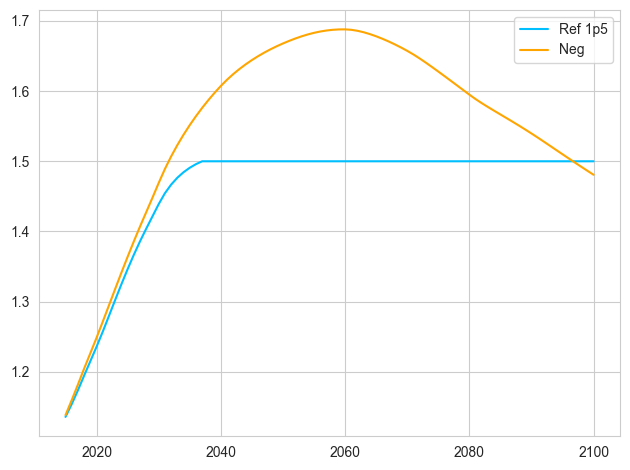

In [30]:
# trjajectories that end close to 1.5 and start between 1.1 and 1
gmt_ref = np.mean(gmt[500:600, :], axis = 0)
gmt_neg = np.mean(gmt[200:300, :], axis = 0)
# gmt_ref[17:] = 1.5
with sns.axes_style('whitegrid'):
    plt.figure()
    plt.plot(np.linspace(2015, 2100, 86), gmt_ref, color = '#00BFFF', label = 'Ref 1p5') 
    plt.plot(np.linspace(2015, 2100, 86), gmt_neg, color = '#FFA500', label = 'Neg')
    plt.legend()
    plt.tight_layout()
    plt.show()

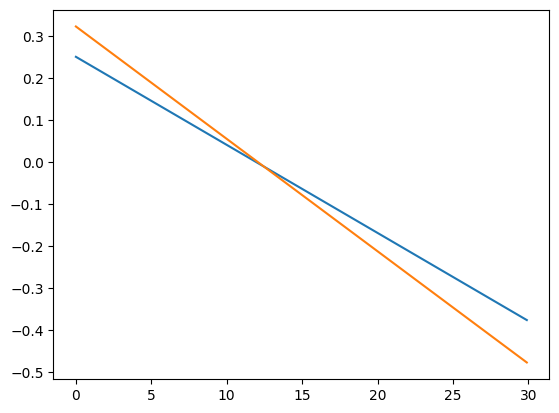

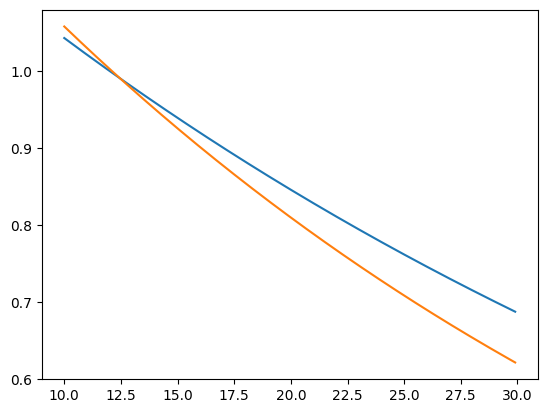

In [197]:

def compute_exc(gmt):
    gmt_tmp       = (gmt-thrshld).copy()
    gmt_tmp[gmt_tmp < 0] = 0
    gmt_exc       = gmt_tmp.sum()/86
    # gmt_tmp     = gmt-(gmt[-1])
    # gmt_tmp[gmt_tmp < 0] = 0
    # gmt_od   = gmt_tmp.sum() 
    gmt_cum = gmt.sum()/86
    gmt_cum_adj = (gmt-1.1455791).sum()/86
    return(gmt_exc)
def compute_uxc(gmt):
    gmt_tmp       = (gmt-thrshld).copy()
    gmt_tmp[gmt_tmp > 0] = 0
    gmt_uxc       =-gmt_tmp.sum()/86
    return(gmt_uxc)

T_baseline = np.arange(0,30,0.1)
eoc_ref    = 1.5
eoc_neg    = 1.5
eoc = 1.5
exc_ref    = compute_exc(gmt_ref)
exc_neg    = compute_exc(gmt_neg)
uxc_ref    = compute_uxc(gmt_ref)
uxc_neg    = compute_uxc(gmt_neg)

# pred_ref = np.array([[0,0] + [eoc, eoc*t] + [exc_ref, exc_ref*t, eoc*exc_ref] + [0]*157 for t in T_baseline])
# pred_neg = np.array([[0,0] + [eoc, eoc*t] + [exc_neg, exc_neg*t, eoc*exc_neg] + [0]*157 for t in T_baseline])
# pred_ref = np.array([[0,0] + [eoc, eoc*t] + [exc_ref, exc_ref*t, eoc*exc_ref] + [0]*157 for t in T_baseline])
# pred_neg = np.array([[0,0] + [eoc, eoc*t] + [exc_neg, exc_neg*t, eoc*exc_neg] + [0]*157 for t in T_baseline])
pred_ref = np.array([[0,0] + [eoc, eoc*t] + [exc_ref, exc_ref*t] + [0]*157 for t in T_baseline])
pred_neg = np.array([[0,0] + [eoc, eoc*t] + [exc_neg, exc_neg*t] + [0]*157 for t in T_baseline])
# pred_ref = np.array([[0,0] + [exc_ref, exc_ref*t] + [0]*157 for t in T_baseline])
# pred_neg = np.array([[0,0] + [exc_neg, exc_neg*t] + [0]*157 for t in T_baseline])

impact_ref = linreg.predict(pred_ref)
impact_neg = linreg.predict(pred_neg)

plt.figure()
plt.plot(T_baseline, impact_ref)
plt.plot(T_baseline, impact_neg)
plt.show()
plt.figure()
plt.plot(T_baseline[100:], np.exp(impact_ref)[100:])
plt.plot(T_baseline[100:], np.exp(impact_neg)[100:])
plt.show()

In [198]:
from matplotlib.colors import LinearSegmentedColormap

focus_countries         = ['DEU', 'NZL', 'USA', 'CHN', 'BRA', 'IND', 'NGA']
focus_countries_names   = ['Germany', 'New Zealand', 'USA', 'China', 'Brazil', 'India', 'Nigeria']
focus_temperatures      = [regression_df[regression_df.iso == country].loc[:, 'tas_baseline'].mean() for country in focus_countries] 
# focus_temperatures[1] = 12.5
colors = ['indigo',
          'm', 
          'orchid',
          'darkseagreen',
          'forestgreen',
          'gold'
          ] 
custom_cmap = LinearSegmentedColormap.from_list('OrangeYellowGreen', colors[::-1], N=256)
focus_colours = custom_cmap(np.linspace(0,1,7))

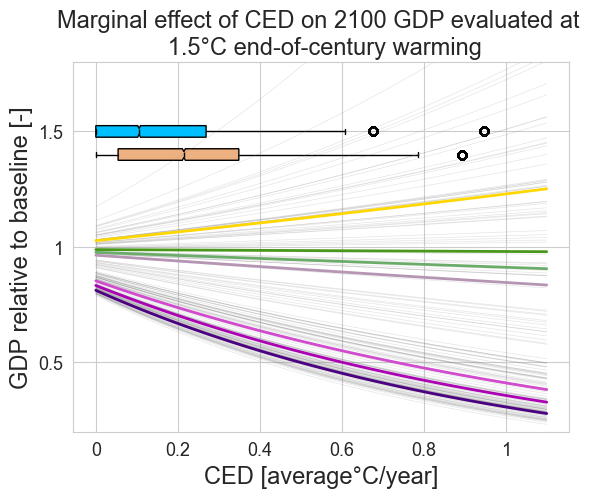

In [211]:
EXCs = np.linspace(0, 1.1, 100)
eoc = 1.5
uxc = 0
pred_exc_warm = np.array([[0,0] + [eoc, eoc*20] + [exc, exc*20]+ [0]*157 for exc in EXCs])
pred_exc_hot = np.array([[0,0] + [eoc, eoc*30] + [exc, exc*30]+ [0]*157 for exc in EXCs])
pred_exc_medium = np.array([[0,0] + [eoc, eoc*13] + [exc, exc*13]+ [0]*157 for exc in EXCs])
pred_exc_cold = np.array([[0,0] + [eoc, eoc*10]+ [exc, exc*10]+ [0]*157 for exc in EXCs])#
# pred_exc_warm = np.array([[0,0] + [exc, exc*20]+ [0]*157 for exc in EXCs])
# pred_exc_hot = np.array([[0,0] + [exc, exc*30]+ [0]*157 for exc in EXCs])
# pred_exc_medium = np.array([[0,0] + [exc, exc*13]+ [0]*157 for exc in EXCs])
# pred_exc_cold = np.array([[0,0] + [exc, exc*10]+ [0]*157 for exc in EXCs])
impact_warm = linreg.predict(pred_exc_warm)
impact_cold = linreg.predict(pred_exc_cold)
impact_medium = linreg.predict(pred_exc_medium)
impact_hot = linreg.predict(pred_exc_hot)

color_ref = '#00BFFF'
color_neg = np.array([0.92907237, 0.68878959, 0.50411509, 1.        ])

with sns.axes_style('whitegrid'):
    plt.figure()
    bar1 = plt.boxplot([regression_df[regression_df.scen_run.str.contains('Ref')].loc[:, 'gmt_exc'].values], 
                positions = [1.5], 
                widths = 0.05, 
                patch_artist = True, 
                boxprops=dict(facecolor=color_ref, color='black'), 
                vert=False, 
                notch = True)
    bar2 = plt.boxplot([regression_df[regression_df.scen_run.str.contains('Neg')].loc[:, 'gmt_exc'].values], 
                positions = [1.4], 
                widths = 0.05, 
                patch_artist = True, 
                boxprops=dict(facecolor=color_neg, color='black'), 
                vert=False, 
                notch = True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bar1[element], color='black')
            plt.setp(bar2[element], color='black')
    for t in np.sort(regression_df.loc[:, 'tas_baseline'].unique())[:]: 
        pred_exc_tmp =  np.array([[0,0] + [eoc, eoc*t] + [exc, exc*t]+ [0]*157 for exc in EXCs])
        # pred_exc_tmp =  np.array([[0,0] + [exc, exc*t]+ [0]*157 for exc in EXCs])
        impact_tmp   = linreg.predict(pred_exc_tmp)
        plt.plot(EXCs, np.exp(impact_tmp), color = 'grey', alpha = .2, lw = 0.5)
    for i, country in enumerate(focus_countries_names):
        t = focus_temperatures[i]
        pred_exc_tmp =  np.array([[0,0] + [eoc, eoc*t] + [exc, exc*t]+ [0]*157 for exc in EXCs])
        # pred_exc_tmp =  np.array([[0,0] +[exc, exc*t]+ [0]*157 for exc in EXCs])
        impact_tmp   = linreg.predict(pred_exc_tmp)
        plt.plot(EXCs, np.exp(impact_tmp), label = focus_countries_names[i], lw = 2, color = focus_colours[i])

    plt.xticks([0,0.2,0.4,0.6,0.8,1],
               ['0','0.2','0.4','0.6','0.8','1'],
               fontsize = labelsize_small)
    plt.yticks([0.5,1,1.5], 
               ['0.5','1','1.5'],
               fontsize = labelsize_small)
    plt.ylim(0.2,1.8)
    plt.xlabel('CED [average°C/year]',
               fontsize = labelsize_large)
    plt.ylabel('GDP relative to baseline [-]',
               fontsize = labelsize_large)
    plt.title('Marginal effect of CED on 2100 GDP evaluated at \n 1.5°C end-of-century warming', fontsize = labelsize_large)
    plt.show()

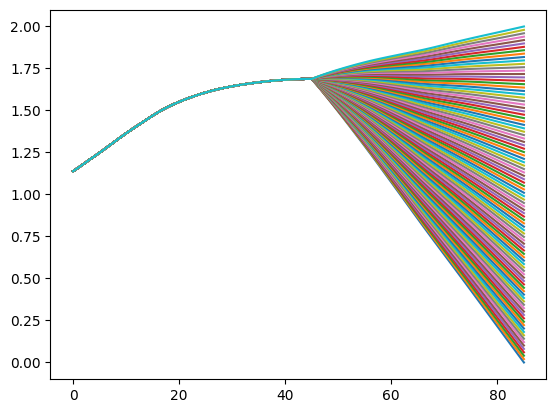

In [201]:
x         = np.linspace(2015, 2100, 86)
p         = np.polyfit([2060, 2100], [gmt_neg[45], gmt_neg[-1]], 1)
y_lin_og  = p[0]*x + p[1]
T_baseline = np.arange(0,30,0.1)
# plt.figure()
# plt.plot(gmt_neg)
# plt.plot(y_lin_og)
# plt.show()

# x_Ts = np.arange(5,30.05,0.05)
x_eocs = np.linspace(0,2,100)

EXCs = []
UXCs = []
# for x_eoc in np.arange(10**,-1,-0.01):
plt.figure()
for x_eoc in x_eocs:
    x         = np.linspace(2015, 2100, 86)
    p         = np.polyfit([2060, 2100], [gmt_neg[45], x_eoc], 1)
    y_lin     = p[0]*x + p[1]
    
    gmt_neg_adj      = gmt_neg.copy()
    gmt_neg_adj[45:] += y_lin[45:] - y_lin_og[45:]
    plt.plot(gmt_neg_adj)
    
    EXCs.append(compute_exc(gmt_neg_adj))
    UXCs.append(compute_uxc(gmt_neg_adj))
plt.show()

In [202]:
IMPACTS_NEG = []
for i, x_eoc in enumerate(x_eocs):
    # pred_tmp = np.array([[0,0] + [x_eoc, x_eoc*t] + [EXCs[i], EXCs[i]*t, x_eoc*EXCs[i]] + [0]*157 for t in T_baseline])
    # pred_tmp = np.array([[0,0] + [x_eoc, x_eoc*t] + [EXCs[i], EXCs[i]*t, x_eoc*EXCs[i]] + [0]*157 for t in T_baseline])
    pred_tmp = np.array([[0,0] + [x_eoc, x_eoc*t] + [EXCs[i], EXCs[i]*t] + [0]*157 for t in T_baseline])
    IMPACTS_NEG.append(linreg.predict(pred_tmp))

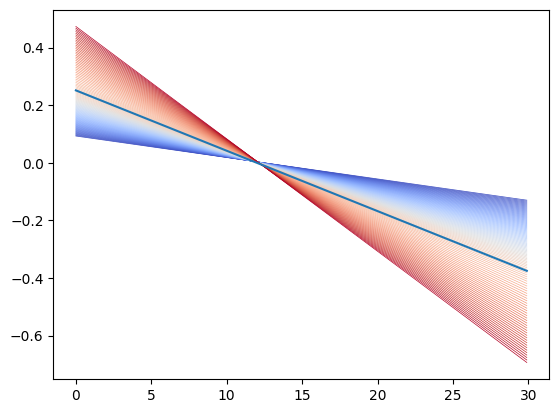

In [203]:
plt.figure()
colors = plt.get_cmap('coolwarm')(np.linspace(0,1,100))
for i in range(len(colors)):
    plt.plot(T_baseline, np.array(IMPACTS_NEG)[i, :], color = colors[i], alpha = 1, lw = 0.5)
plt.plot(T_baseline, impact_ref)
plt.show()

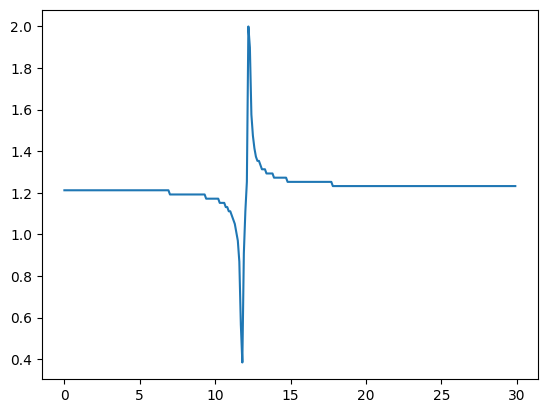

In [204]:
idx_min = np.abs(np.array(IMPACTS_NEG)-impact_ref).argmin(axis = 0)
plt.figure()
plt.plot(T_baseline, x_eocs[idx_min])
# plt.axvline(11.9)
plt.show()

In [205]:
gmt_trajectories_equal = []

for i in range(len(T_baseline)): 
    idx    = idx_min[i]
    x_eoc  = x_eocs[idx]
    
    x         = np.linspace(2015, 2100, 86)
    p         = np.polyfit([2060, 2100], [gmt_neg[45], x_eoc], 1)
    y_lin     = p[0]*x + p[1]

    gmt_neg_adj      = gmt_neg.copy()
    gmt_neg_adj[45:] += y_lin[45:]-y_lin_og[45:]
    
    gmt_trajectories_equal.append(gmt_neg_adj)
    
gmt_trajectories_equal = np.array(gmt_trajectories_equal)

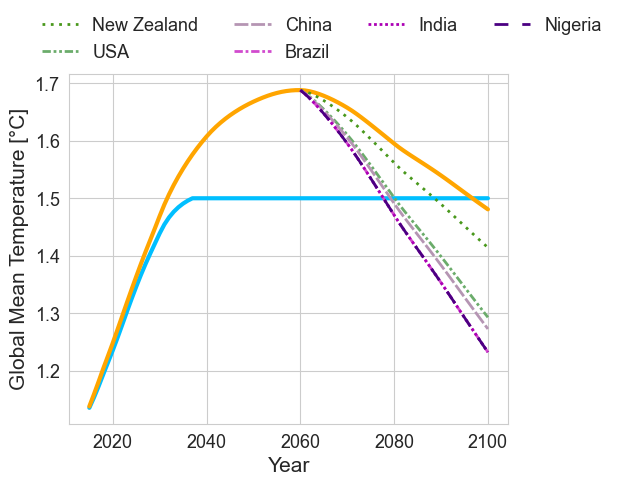

In [206]:
from matplotlib.colors import LinearSegmentedColormap
#new zealand (NZL) is pretty much zero 
# focus_countries         = ['NZL', 'USA', 'CHN', 'BRA', 'IND', 'NGA']
# focus_countries_names   = ['New Zealand', 'USA', 'China', 'Brazil', 'India', 'Nigeria']
# focus_temperatures      = [regression_df[regression_df.iso == country].loc[:, 'tas_baseline'].mean() for country in focus_countries] 
# # focus_temperatures[0] = 11.4
# # Create a custom colormap
# colors = ['indigo',
#           'm', 
#           'orchid',
#           'darkseagreen',
#           'forestgreen',
#           'darkslategrey'
#           ] 
# custom_cmap = LinearSegmentedColormap.from_list('OrangeYellowGreen', colors[::-1], N=256)
# focus_colours = custom_cmap(np.linspace(0,1,6))

focus_linestyles        = [ (0,(1, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5,1)), (0,(3, 1, 1, 1)), (0, (1,1)), (0, (5,5))] 
idx_country = [np.abs(T_baseline-focus_temperatures[i_country]).argmin() for i_country in range(len(focus_countries))]
with sns.axes_style('whitegrid'):
    with sns.axes_style('whitegrid'):
        plt.figure(figsize = (6,5))
        plt.plot(np.linspace(2015,2100,86), gmt_ref, color = '#00BFFF', linewidth = 3)
        plt.plot(np.linspace(2015,2100,86), gmt_neg, color = '#FFA500', linewidth = 3)
        # lc  = multiline(np.array([np.linspace(2015,2100,86)[45:] for i in range(501-150)]),  gmt_trajectories_equal[150:, 45:], x_Ts[150:], cmap='RdBu_r', lw=2, alpha =.1)
        for i_country in range(1, len(focus_countries)):
            # print(i_country)
            # print(idx_country[i_country])
            plt.plot(np.linspace(2015,2100,86)[45:], 
                     gmt_trajectories_equal[idx_country[i_country], 45:], 
                     color = focus_colours[i_country], 
                     label = focus_countries_names[i_country], 
                     linewidth = 2, 
                     linestyle = focus_linestyles[i_country-1])
        plt.tick_params(labelsize = 13)
        plt.xlabel('Year', fontsize = 15)
        plt.ylabel('Global Mean Temperature [°C]', fontsize = 15)
        plt.legend(ncols = 4, loc  = 'center left', frameon = False, bbox_to_anchor=(-0.1, 1.1), fontsize = 13)
        plt.tight_layout()
        plt.show()

### Plot

In [213]:
cmap   = sns.color_palette("flare", as_cmap=True)
colors = ['blue', '#00BFFF'] + list(cmap(np.linspace(0,1,len(cset.focus_scenarios)-2)))
color_ref = '#00BFFF'
color_neg = np.array([0.92907237, 0.68878959, 0.50411509, 1.        ])
scen_colors = [color_ref, color_neg]

In [214]:
gdp_2100_df = gdp_df.loc[gdp_df.year == 2100]
gmt_ds = pd.read_csv(cset.path_MESMER_char / f'gmt_dataset.csv', index_col = 0)

In [215]:
# worldmap data
indicator = 'diff_SSP2'
gdp_ref_df = gdp_2100_df.loc[((gdp_df.scen == 'Ref')), ['iso', indicator]].groupby('iso').median()
gdp_neg_df = gdp_2100_df.loc[((gdp_df.scen == 'Neg')), ['iso', indicator]].groupby('iso').median()

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

for iso in gdp_ref_df.index: 
    world.loc[iso, 'gdp_ref'] = gdp_ref_df.loc[iso, indicator]
    world.loc[iso, 'gdp_neg'] = gdp_neg_df.loc[iso, indicator]
world['SSP_ref-neg'] = (world.gdp_ref-world.gdp_neg)/(world.gdp_ref)*100

In [216]:
# boxplot data
def rename(newname):
    def decorator(f):
        f.__name__ = newname
        return f
    return decorator

def q_at(y):
    @rename(f'q{y:0.2f}')
    def q(x):
        return x.quantile(y)
    return q
    
f = {'diff_SSP2': [q_at(q) for q in [0.05,0.1,0.5,0.9,0.95]]}

boxplot_arr = []
for scen in cset.focus_scenarios:
    boxplot_arr.append(gdp_2100_df[gdp_2100_df.scen == scen].groupby('run').agg(f).loc[:, 'diff_SSP2'].values)
boxplot_arr = np.array(boxplot_arr)

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_12391/3866504876.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm').copy()
/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


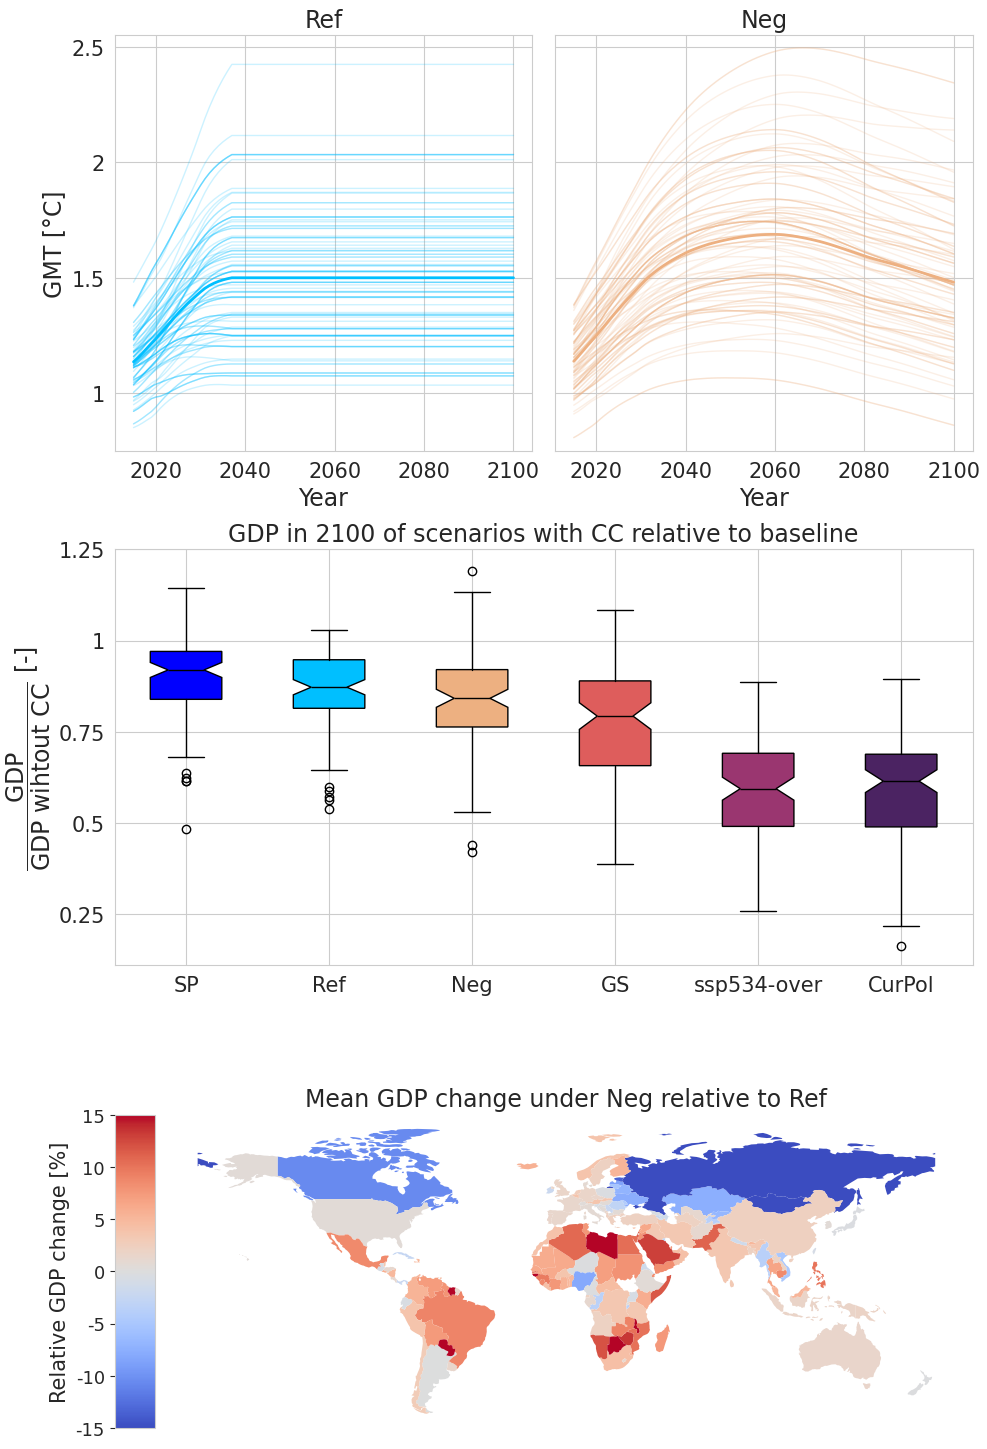

In [75]:
axes = []
with sns.axes_style('whitegrid'): 
        fig = plt.figure(figsize=(10, 15))
        gs  = GridSpec(3, 2, figure=fig)
    
        for i, scen in enumerate(['Ref', 'Neg']):
                ax = fig.add_subplot(gs[0, i])
                ax.plot(np.arange(2015,2101,1), 
                        gmt_ds.loc[:, gmt_ds.columns.str.contains(scen)].values,
                        color = scen_colors[i],
                        alpha = .2,
                        lw = 1)
                
                ax.plot(np.arange(2015,2101,1), 
                        gmt_ds.loc[:, gmt_ds.columns.str.contains(scen)].values.mean(axis = 1),
                        color = scen_colors[i],
                        lw = 2, zorder = 10)
                ax.set_xticks([2020, 2040, 2060, 2080, 2100],
                        ['2020', '2040', '2060', '2080', '2100'],
                        fontsize = labelsize_medium)
                ax.set_ylim(0.75,2.55)
                if i == 0:
                        ax.set_yticks([1,1.5,2,2.5],
                                [1,1.5,2,2.5], 
                                fontsize = labelsize_medium)
                        ax.set_ylabel('GMT [°C]', 
                                fontsize = labelsize_large)
                if i == 1: 
                        ax.set_yticks([1,1.5,2,2.5],
                                [],
                                fontsize = labelsize_medium)
                ax.set_title(scen, fontsize = labelsize_large)
                ax.set_xlabel('Year', fontsize = labelsize_large)            
                axes.append(ax)

        ax = fig.add_subplot(gs[1,:])
        bplot = ax.boxplot(boxplot_arr[:, :, 2].T, notch = True, 
                patch_artist = True)
        for patch, color in zip(bplot['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_edgecolor('black')
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
                plt.setp(bplot[element], color='black')
        ax.set_xticks(np.arange(1, 1+cset.n_focus_scenarios),
                        cset.focus_scenarios, 
                        fontsize=labelsize_medium)
        ax.set_yticks([0.25, 0.5, 0.75, 1, 1.25],
                        [0.25, 0.5, 0.75, 1, 1.25],
                        fontsize=labelsize_medium)
        ax.set_ylabel(r'$\dfrac{{\text{GDP}}}{{\text{GDP wihtout CC}}}$ [-]', 
                      fontsize=labelsize_large)   
        ax.set_title('GDP in 2100 of scenarios with CC relative to baseline', 
                     fontsize = labelsize_large)    
        axes.append(ax)
        
        ax = fig.add_subplot(gs[2,:])
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('left', size='5%', pad=0.05)

        cmap = plt.cm.get_cmap('coolwarm').copy()
        # cmap.set_extremes(under='yellow', over='orange')
        worldmap = world.plot(column = 'SSP_ref-neg', 
                   ax=ax, legend=True, 
                   cmap = cmap, 
                   cax=cax, 
                   vmin = -15, 
                   vmax = 15,)
        ax.set_axis_off()
        ax.set_title('Mean GDP change under Neg relative to Ref', 
                     fontsize = labelsize_large)
        cax.yaxis.tick_left()
        cax.yaxis.set_label_position("left")
        # cax.yaxis.set_extent([-10, 10])
        cax.set_yticks([-15, -10, -5, 0, 5, 10, 15],
                       [-15, -10, -5, 0, 5, 10, 15],
                       fontsize = labelsize_small)
        cax.set_ylabel('Relative GDP change [%]', 
                       fontsize = labelsize_medium)
        #cax.colorbar.extend = 'both'
        # cbar = fig.colorbar(worldmap.get_figure().axes[-1].collections[0], cax=cax, extend='both')
        # extended_ticks = True
        plt.tight_layout()

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_12391/12323735.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm').copy()
/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


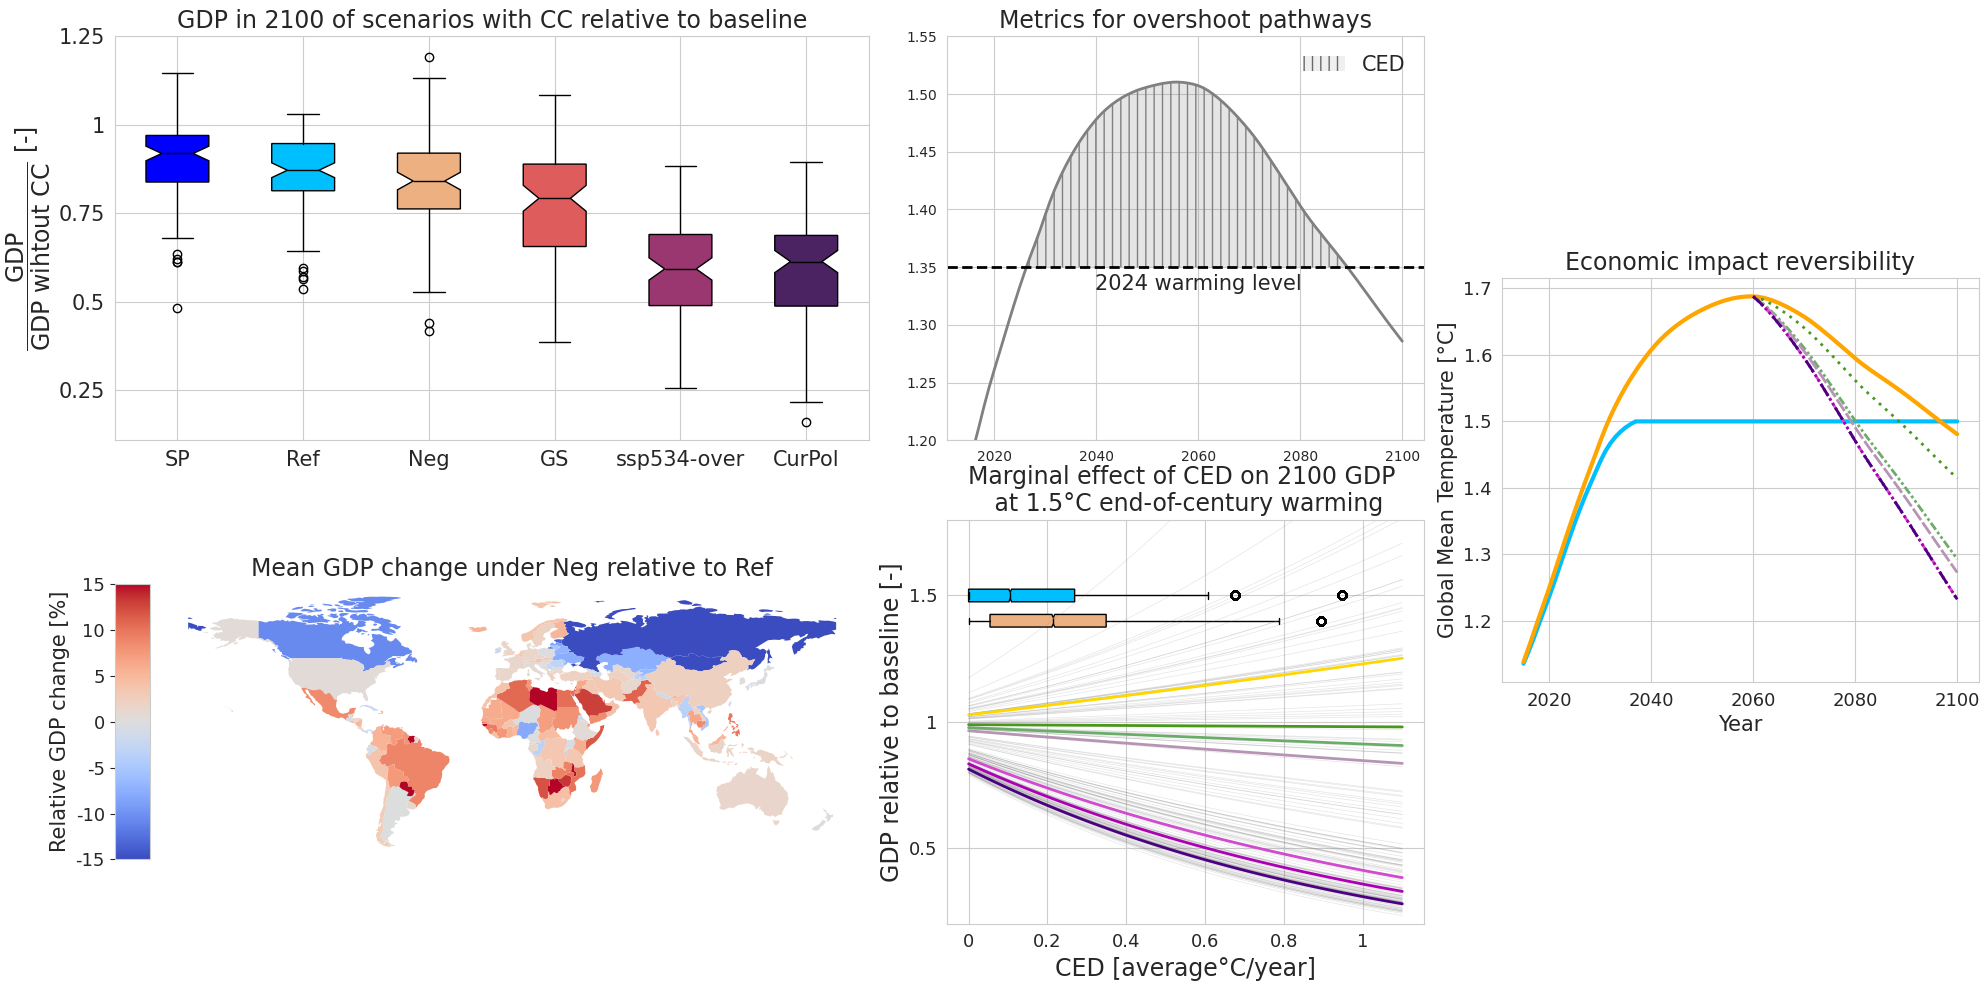

In [217]:
axes = []
with sns.axes_style('whitegrid'): 
        fig = plt.figure(figsize=(20, 10))
        gs  = GridSpec(8, 7, figure=fig)

        ax = fig.add_subplot(gs[:4,:3])
        bplot = ax.boxplot(boxplot_arr[:, :, 2].T, notch = True, 
                patch_artist = True)
        for patch, color in zip(bplot['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_edgecolor('black')
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
                plt.setp(bplot[element], color='black')
        ax.set_xticks(np.arange(1, 1+cset.n_focus_scenarios),
                        cset.focus_scenarios, 
                        fontsize=labelsize_medium)
        ax.set_yticks([0.25, 0.5, 0.75, 1, 1.25],
                        [0.25, 0.5, 0.75, 1, 1.25],
                        fontsize=labelsize_medium)
        ax.set_ylabel(r'$\dfrac{{\text{GDP}}}{{\text{GDP wihtout CC}}}$ [-]', 
                      fontsize=labelsize_large)   
        ax.set_title('GDP in 2100 of scenarios with CC relative to baseline', 
                     fontsize = labelsize_large)    
        axes.append(ax)
        
        ax = fig.add_subplot(gs[4:,:3])
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('left', size='5%', pad=0.05)

        cmap = plt.cm.get_cmap('coolwarm').copy()
        # cmap.set_extremes(under='yellow', over='orange')
        worldmap = world.plot(column = 'SSP_ref-neg', 
                   ax=ax, legend=True, 
                   cmap = cmap, 
                   cax=cax, 
                   vmin = -15, 
                   vmax = 15,)
        ax.set_axis_off()
        ax.set_title('Mean GDP change under Neg relative to Ref', 
                     fontsize = labelsize_large)
        cax.yaxis.tick_left()
        cax.yaxis.set_label_position("left")
        # cax.yaxis.set_extent([-10, 10])
        cax.set_yticks([-15, -10, -5, 0, 5, 10, 15],
                       [-15, -10, -5, 0, 5, 10, 15],
                       fontsize = labelsize_small)
        cax.set_ylabel('Relative GDP change [%]', 
                       fontsize = labelsize_medium)
        
        ax = fig.add_subplot(gs[:4,3:5])
        ax.plot(gmt_ds.index, gmt_ds.iloc[:, 215], color = 'grey', lw = 2)
        ax.axhline(1.35, color = 'black', linestyle = '--', lw = 2)
        ax.text(2060, 1.33, '2024 warming level', fontsize = labelsize_medium, ha = 'center')
        t_ref  =1.35
        gmt_trajectories_adj = gmt_ds.iloc[:, 215].copy().values
        gmt_trajectories_adj[gmt_trajectories_adj < t_ref] = t_ref
        ax.fill_between(gmt_ds.index, np.repeat(t_ref, len(gmt_ds.index)), gmt_trajectories_adj, 
                        color = 'grey', edgecolor = 'None', alpha = .2, hatch = '||')    
        ax.fill_between(gmt_ds.index, 0, 0, 
                    color = 'dimgrey', edgecolor = 'None', alpha = .1, hatch = '||', label = 'CED')    
        ax.legend(ncol = 1, fontsize = labelsize_medium, loc = 'upper right', frameon = False)
        ax.set_ylim(1.2, 1.55)
        ax.set_title('Metrics for overshoot pathways', fontsize = labelsize_large)
        axes.append(ax)
        
        ax = fig.add_subplot(gs[4:,3:5])
        bar1 = ax.boxplot([regression_df[regression_df.scen_run.str.contains('Ref')].loc[:, 'gmt_exc'].values], 
                        positions = [1.5], 
                        widths = 0.05, 
                        patch_artist = True, 
                        boxprops=dict(facecolor=color_ref, color='black'), 
                        vert=False, 
                        notch = True)
        bar2 = ax.boxplot([regression_df[regression_df.scen_run.str.contains('Neg')].loc[:, 'gmt_exc'].values], 
                        positions = [1.4], 
                        widths = 0.05, 
                        patch_artist = True, 
                        boxprops=dict(facecolor=color_neg, color='black'), 
                        vert=False, 
                        notch = True)
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
                plt.setp(bar1[element], color='black')
                plt.setp(bar2[element], color='black')
        for t in np.sort(regression_df.loc[:, 'tas_baseline'].unique())[:]: 
                pred_exc_tmp =  np.array([[0,0] + [eoc, eoc*t] + [exc, exc*t]+ [0]*157 for exc in EXCs])
                impact_tmp   = linreg.predict(pred_exc_tmp)
                plt.plot(EXCs, np.exp(impact_tmp), color = 'grey', alpha = .2, lw = 0.5)
        for i, country in enumerate(focus_countries_names):
                t = focus_temperatures[i]
                pred_exc_tmp =  np.array([[0,0] + [eoc, eoc*t] + [exc, exc*t]+ [0]*157 for exc in EXCs])
                impact_tmp   = linreg.predict(pred_exc_tmp)
                plt.plot(EXCs, np.exp(impact_tmp), label = focus_countries_names[i], lw = 2, color = focus_colours[i])

        ax.set_xticks([0,0.2,0.4,0.6,0.8,1],
                ['0','0.2','0.4','0.6','0.8','1'],
                fontsize = labelsize_small)
        ax.set_yticks([0.5,1,1.5], 
                ['0.5','1','1.5'],
                fontsize = labelsize_small)
        ax.set_ylim(0.2,1.8)
        ax.set_xlabel('CED [average°C/year]',
                fontsize = labelsize_large)
        ax.set_ylabel('GDP relative to baseline [-]',
                fontsize = labelsize_large)
        ax.set_title('Marginal effect of CED on 2100 GDP \n at 1.5°C end-of-century warming', fontsize = labelsize_large)       
        axes.append(ax)
        
        ax = fig.add_subplot(gs[2:-2,5:])
        ax.plot(np.linspace(2015,2100,86), gmt_ref, color = '#00BFFF', linewidth = 3)
        ax.plot(np.linspace(2015,2100,86), gmt_neg, color = '#FFA500', linewidth = 3)
        # lc  = multiline(np.array([np.linspace(2015,2100,86)[45:] for i in range(501-150)]),  gmt_trajectories_equal[150:, 45:], x_Ts[150:], cmap='RdBu_r', lw=2, alpha =.1)
        for i_country in range(1, len(focus_countries)):
            # print(i_country)
            # print(idx_country[i_country])
            ax.plot(np.linspace(2015,2100,86)[45:], 
                     gmt_trajectories_equal[idx_country[i_country], 45:], 
                     color = focus_colours[i_country], 
                     label = focus_countries_names[i_country], 
                     linewidth = 2, 
                     linestyle = focus_linestyles[i_country-1])
        ax.tick_params(labelsize = 13)
        ax.set_xlabel('Year', fontsize = 15)
        ax.set_ylabel('Global Mean Temperature [°C]', fontsize = 15)
        ax.set_title('Economic impact reversibility', fontsize = labelsize_large)
        #cax.colorbar.extend = 'both'
        # cbar = fig.colorbar(worldmap.get_figure().axes[-1].collections[0], cax=cax, extend='both')
        # extended_ticks = True
        fig.tight_layout(h_pad=0.2)

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_12391/332321915.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm').copy()
/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


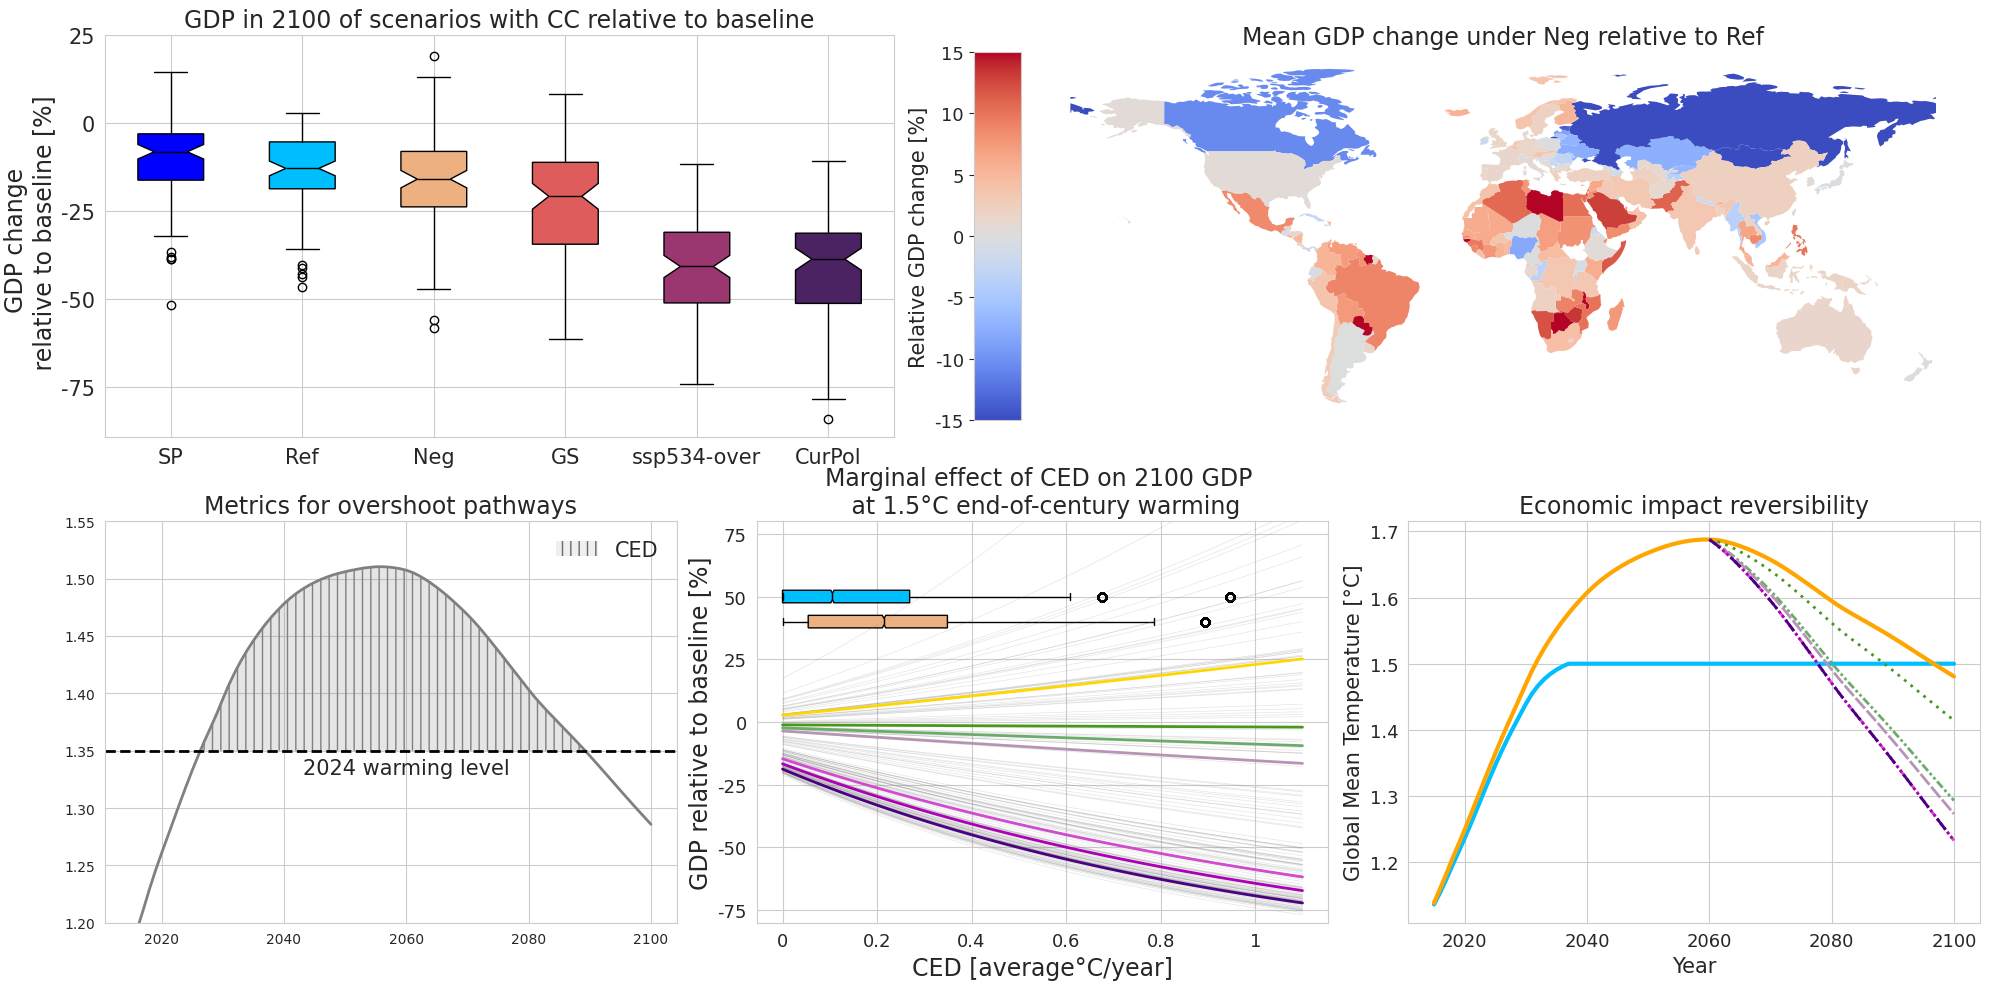

In [229]:
axes = []
with sns.axes_style('whitegrid'): 
        fig = plt.figure(figsize=(20, 10))
        gs  = GridSpec(8, 9, figure=fig)

        ax = fig.add_subplot(gs[:4,:4])
        bplot = ax.boxplot((boxplot_arr[:, :, 2]-1).T*100, notch = True, 
                patch_artist = True)
        for patch, color in zip(bplot['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_edgecolor('black')
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
                plt.setp(bplot[element], color='black')
        ax.set_xticks(np.arange(1, 1+cset.n_focus_scenarios),
                        cset.focus_scenarios, 
                        fontsize=labelsize_medium)
        ax.set_yticks([-75, -50, -25, 0, 25],
                      [-75, -50, -25, 0, 25],
                      fontsize=labelsize_medium)
        ax.set_ylabel('GDP change \n relative to baseline [%]', 
                      fontsize=labelsize_large)   
        ax.set_title('GDP in 2100 of scenarios with CC relative to baseline', 
                     fontsize = labelsize_large)    
        axes.append(ax)
        
        ax = fig.add_subplot(gs[:4,4:])
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('left', size='5%', pad=0.05)

        cmap = plt.cm.get_cmap('coolwarm').copy()
        # cmap.set_extremes(under='yellow', over='orange')
        worldmap = world.plot(column = 'SSP_ref-neg', 
                   ax=ax, legend=True, 
                   cmap = cmap, 
                   cax=cax, 
                   vmin = -15, 
                   vmax = 15,)
        ax.set_axis_off()
        ax.set_title('Mean GDP change under Neg relative to Ref', 
                     fontsize = labelsize_large)
        cax.yaxis.tick_left()
        cax.yaxis.set_label_position("left")
        # cax.yaxis.set_extent([-10, 10])
        cax.set_yticks([-15, -10, -5, 0, 5, 10, 15],
                       [-15, -10, -5, 0, 5, 10, 15],
                       fontsize = labelsize_small)
        cax.set_ylabel('Relative GDP change [%]', 
                       fontsize = labelsize_medium)
        
        ax = fig.add_subplot(gs[4:,:3])
        ax.plot(gmt_ds.index, gmt_ds.iloc[:, 215], color = 'grey', lw = 2)
        ax.axhline(1.35, color = 'black', linestyle = '--', lw = 2)
        ax.text(2060, 1.33, '2024 warming level', fontsize = labelsize_medium, ha = 'center')
        t_ref  =1.35
        gmt_trajectories_adj = gmt_ds.iloc[:, 215].copy().values
        gmt_trajectories_adj[gmt_trajectories_adj < t_ref] = t_ref
        ax.fill_between(gmt_ds.index, np.repeat(t_ref, len(gmt_ds.index)), gmt_trajectories_adj, 
                        color = 'grey', edgecolor = 'None', alpha = .2, hatch = '||')    
        ax.fill_between(gmt_ds.index, 0, 0, 
                    color = 'dimgrey', edgecolor = 'None', alpha = .1, hatch = '||', label = 'CED')    
        ax.legend(ncol = 1, fontsize = labelsize_medium, loc = 'upper right', frameon = False)
        ax.set_ylim(1.2, 1.55)
        ax.set_title('Metrics for overshoot pathways', fontsize = labelsize_large)
        axes.append(ax)
        
        ax = fig.add_subplot(gs[4:,3:6])
        bar1 = ax.boxplot([regression_df[regression_df.scen_run.str.contains('Ref')].loc[:, 'gmt_exc'].values], 
                        positions = [50], 
                        widths = 5, 
                        patch_artist = True, 
                        boxprops=dict(facecolor=color_ref, color='black'), 
                        vert=False, 
                        notch = True)
        bar2 = ax.boxplot([regression_df[regression_df.scen_run.str.contains('Neg')].loc[:, 'gmt_exc'].values], 
                        positions = [40], 
                        widths = 5, 
                        patch_artist = True, 
                        boxprops=dict(facecolor=color_neg, color='black'), 
                        vert=False, 
                        notch = True)
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
                plt.setp(bar1[element], color='black')
                plt.setp(bar2[element], color='black')
        for t in np.sort(regression_df.loc[:, 'tas_baseline'].unique())[:]: 
                pred_exc_tmp =  np.array([[0,0] + [eoc, eoc*t] + [exc, exc*t]+ [0]*157 for exc in EXCs])
                impact_tmp   = linreg.predict(pred_exc_tmp)
                plt.plot(EXCs, (np.exp(impact_tmp)-1)*100, color = 'grey', alpha = .2, lw = 0.5)
        for i, country in enumerate(focus_countries_names):
                t = focus_temperatures[i]
                pred_exc_tmp =  np.array([[0,0] + [eoc, eoc*t] + [exc, exc*t]+ [0]*157 for exc in EXCs])
                impact_tmp   = linreg.predict(pred_exc_tmp)
                plt.plot(EXCs, (np.exp(impact_tmp)-1)*100, label = focus_countries_names[i], lw = 2, color = focus_colours[i])

        ax.set_xticks([0,0.2,0.4,0.6,0.8,1],
                [0,0.2,0.4,0.6,0.8,1],
                fontsize = labelsize_small)
        ax.set_yticks([-75,-50,-25,0,25,50, 75],
                 [-75,-50,-25,0,25,50, 75],
                fontsize = labelsize_small)
        ax.set_ylim(-80,80)
        ax.set_xlabel('CED [average°C/year]',
                fontsize = labelsize_large)
        ax.set_ylabel('GDP relative to baseline [%]',
                fontsize = labelsize_large)
        ax.set_title('Marginal effect of CED on 2100 GDP \n at 1.5°C end-of-century warming', fontsize = labelsize_large)       
        axes.append(ax)
        
        ax = fig.add_subplot(gs[4:,6:])
        ax.plot(np.linspace(2015,2100,86), gmt_ref, color = '#00BFFF', linewidth = 3)
        ax.plot(np.linspace(2015,2100,86), gmt_neg, color = '#FFA500', linewidth = 3)
        # lc  = multiline(np.array([np.linspace(2015,2100,86)[45:] for i in range(501-150)]),  gmt_trajectories_equal[150:, 45:], x_Ts[150:], cmap='RdBu_r', lw=2, alpha =.1)
        for i_country in range(1, len(focus_countries)):
            # print(i_country)
            # print(idx_country[i_country])
            ax.plot(np.linspace(2015,2100,86)[45:], 
                     gmt_trajectories_equal[idx_country[i_country], 45:], 
                     color = focus_colours[i_country], 
                     label = focus_countries_names[i_country], 
                     linewidth = 2, 
                     linestyle = focus_linestyles[i_country-1])
        ax.tick_params(labelsize = 13)
        ax.set_xlabel('Year', fontsize = 15)
        ax.set_ylabel('Global Mean Temperature [°C]', fontsize = 15)
        ax.set_title('Economic impact reversibility', fontsize = labelsize_large)
        #cax.colorbar.extend = 'both'
        # cbar = fig.colorbar(worldmap.get_figure().axes[-1].collections[0], cax=cax, extend='both')
        # extended_ticks = True
        fig.tight_layout(h_pad=0.2)

### Store Analysis Results


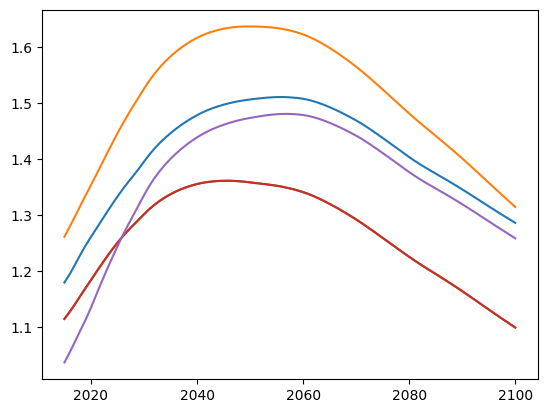

In [98]:
# store this: 
for i in range(15,20):
    plt.plot(gmt_ds.index, gmt_ds.iloc[:, 200 +i])

In [153]:
np.median(gmt_ds.loc[:, gmt_ds.columns.str.contains('ssp534-over')].values[-1,:])

1.8421500000000002

In [155]:
np.median(gmt_ds.loc[:, gmt_ds.columns.str.contains('CurPol')].values[-1,:])

2.8928000000000003

In [124]:
gdp_2100_df[gdp_2100_df.scen == 'Neg'].loc[:, 'diff_SSP2'].mean()

0.914893983993525

In [125]:
gdp_2100_df[gdp_2100_df.scen == 'Ref'].loc[:, 'diff_SSP2'].mean()

0.9119420225908327

In [126]:
gdp_2100_df[gdp_2100_df.scen == 'Neg'].loc[:, 'diff_SSP2'].median()

0.8642937731838152

In [146]:
(gdp_2100_df[gdp_2100_df.scen == 'Neg'].groupby('run').median('diff_SSP2').median()-gdp_2100_df[gdp_2100_df.scen == 'Ref'].groupby('run').median('diff_SSP2').median())/gdp_2100_df[gdp_2100_df.scen == 'Neg'].groupby('run').median('diff_SSP2').median()

year         0.000000
diff_SSP2   -0.036265
SSP2         0.000000
dtype: float64

In [144]:
(gdp_2100_df[gdp_2100_df.scen == 'ssp534-over'].groupby('run').median('diff_SSP2').median()-gdp_2100_df[gdp_2100_df.scen == 'CurPol'].groupby('run').median('diff_SSP2').median())/gdp_2100_df[gdp_2100_df.scen == 'ssp534-over'].groupby('run').median('diff_SSP2').median()

year         0.000000
diff_SSP2   -0.035087
SSP2         0.000000
dtype: float64

In [181]:
np.argsort((gdp_2100_df[gdp_2100_df.scen == 'Ref'].groupby('iso').mean('diff_SSP2').loc[:, 'diff_SSP2'].values-gdp_2100_df[gdp_2100_df.scen == 'Neg'].groupby('iso').mean('diff_SSP2').loc[:, 'diff_SSP2'].values)/(1-gdp_2100_df[gdp_2100_df.scen == 'Ref'].groupby('iso').mean('diff_SSP2').loc[:, 'diff_SSP2'].values))

array([ 93,  78,  15,  27,  14,  65, 124, 104, 152, 138,  26,  29,  11,
        23, 123, 137,  52,  43,  12, 136,  13, 153,  31,  79, 146, 119,
       127,  34,  41,  56,  28,  60, 105, 117,  48, 122,  94,  49,  64,
         9,  68, 103,  82,  30,  77, 120,  17,  38,  95,  99,   4,  58,
        73,  63, 101,   3,  62,  91,  80,  25,  35, 115, 125, 131,  84,
       108,  72,  81, 148, 112,  61,  70, 132,   7,  32,  90, 144, 126,
       113,  50,   6,  53,   1, 135,   5,  36,  71, 114,  33, 110,  44,
        67,  51,  24,   8,  87,  20,  85, 111,  37, 139,  21, 130,  10,
       151,  66, 145,  75, 128,  46, 116, 106, 134, 109,  92,   0,  57,
       141,  54,  42,  74,  89,  69,  16, 147,  88,  76,  55, 129,  59,
        86,   2,  96,  39,  18, 154,  83,  45, 107,  47, 102,  40, 133,
        98, 121,  19, 156, 118, 100, 143, 155, 142, 149,  97,  22, 140,
       150])

In [183]:
gdp_2100_df[gdp_2100_df.scen == 'Neg'].groupby('iso').median('diff_SSP2').loc[:, 'diff_SSP2'].index[np.argsort((gdp_2100_df[gdp_2100_df.scen == 'Ref'].groupby('iso').mean('diff_SSP2').loc[:, 'diff_SSP2'].values-gdp_2100_df[gdp_2100_df.scen == 'Neg'].groupby('iso').mean('diff_SSP2').loc[:, 'diff_SSP2'].values)/(1-gdp_2100_df[gdp_2100_df.scen == 'Ref'].groupby('iso').mean('diff_SSP2').loc[:, 'diff_SSP2'].values))]

Index(['MKD', 'KOR', 'BIH', 'CHN', 'BGR', 'IND', 'SDN', 'NGA', 'VNM', 'THA',
       ...
       'PRY', 'MWI', 'TUR', 'ZMB', 'TUN', 'USA', 'MNG', 'BWA', 'TKM', 'UZB'],
      dtype='object', name='iso', length=157)

In [171]:
gdp_2100_df[gdp_2100_df.scen == 'Neg'].groupby('iso').median('diff_SSP2').loc[:, 'diff_SSP2'].index[93]

'MKD'

In [177]:
gdp_2100_df[gdp_2100_df.scen == 'Neg'].groupby('iso').median('diff_SSP2').loc[:, 'diff_SSP2'].loc['SAU']

0.5010613701584525

In [178]:
gdp_2100_df[gdp_2100_df.scen == 'Ref'].groupby('iso').median('diff_SSP2').loc[:, 'diff_SSP2'].loc['SAU']

0.5755370698034505

In [159]:
1-gdp_2100_df[gdp_2100_df.scen == 'Ref'].groupby('iso').median('diff_SSP2').loc[:, 'diff_SSP2'].values

array([ 5.23281140e-02,  2.87318302e-01,  7.38888071e-02,  4.69265085e-01,
        1.29557342e-01, -1.51338278e-01,  8.32110870e-02, -1.56102302e-01,
       -1.56430245e-01,  2.35067693e-01, -4.54013581e-02,  2.83338586e-01,
        3.90201759e-01,  3.16830863e-01, -2.22763756e-02,  1.03122210e-03,
       -1.12399971e-01,  2.80756981e-01,  1.92459120e-01,  2.38427004e-01,
        2.49342142e-01,  1.73440231e-01,  2.33012191e-01,  2.95866753e-01,
       -2.95696987e-01, -1.30732335e-01, -1.63530131e-01, -2.04320734e-02,
        2.60962356e-01,  2.78765570e-01,  2.34048008e-01,  2.92041248e-01,
        2.85910224e-01,  2.72928507e-01,  2.81773127e-01,  2.94341386e-01,
       -1.31549525e-01, -7.59860865e-02,  3.53857139e-01, -6.69327533e-02,
        1.37530327e-01,  2.31549643e-01,  2.72839469e-01,  4.09437202e-01,
        4.16397215e-02, -1.70171462e-01,  2.21722362e-01, -3.73889930e-01,
       -1.59174110e-02,  2.66991862e-01, -4.49939002e-02, -1.44634200e-01,
        2.52950353e-01,  

In [141]:
gdp_2100_df[gdp_2100_df.scen == 'Neg'].groupby('run').median('diff_SSP2').median()

year          2100.000000
diff_SSP2        0.841346
SSP2         65169.428348
dtype: float64

In [129]:
(gdp_2100_df[gdp_2100_df.scen == 'Ref'].loc[:, 'diff_SSP2'].median()-gdp_2100_df[gdp_2100_df.scen == 'Neg'].loc[:, 'diff_SSP2'].median())/gdp_2100_df[gdp_2100_df.scen == 'Ref'].loc[:, 'diff_SSP2'].median()

0.025679853753668318

In [131]:
(gdp_2100_df[gdp_2100_df.scen == 'Ref'].loc[:, 'diff_SSP2'].median()-gdp_2100_df[gdp_2100_df.scen == 'Neg'].loc[:, 'diff_SSP2'].median())/gdp_2100_df[gdp_2100_df.scen == 'Ref'].loc[:, 'diff_SSP2'].median()

0.025679853753668318

In [136]:
(gdp_2100_df[gdp_2100_df.scen == 'ssp534-over'].loc[:, 'diff_SSP2'].median()-gdp_2100_df[gdp_2100_df.scen == 'CurPol'].loc[:, 'diff_SSP2'].median())/gdp_2100_df[gdp_2100_df.scen == 'CurPol'].loc[:, 'diff_SSP2'].median()*100

-1.0717694586632471